# Metadata And Export Example

**Comprehensive example: Metadata management and export functionality**


This example demonstrates:
1. Building a pipeline with multiple queries
2. Setting source metadata (descriptions, PII flags, ownership)
3. Propagating metadata through lineage
4. Generating descriptions with LLM (optional)
5. Exporting to multiple formats (JSON, CSV, DOT visualization)
6. Using diff to track changes

### Imports

In [1]:
import tempfile
from pathlib import Path

# Add src to path for direct execution
from clgraph import (
    CSVExporter,
    JSONExporter,
    Pipeline,
    visualize_pipeline_lineage,
)

### Code

In [2]:
print("Metadata Management and Export Example")
print()

Metadata Management and Export Example



### Section

In [3]:
print("Step 1: Building data pipeline...")

sql_queries = [
    # Stage 1: Raw data ingestion
    (
        "raw_events",
        """
        CREATE OR REPLACE TABLE raw.user_events AS
        SELECT
            user_id,
            event_type,
            event_timestamp,
            user_email,
            ip_address,
            session_id
        FROM source_system.events
        WHERE event_timestamp >= '2024-01-01'
        """,
    ),
    # Stage 2: Daily aggregation
    (
        "daily_metrics",
        """
        CREATE OR REPLACE TABLE staging.daily_metrics AS
        SELECT
            user_id,
            DATE(event_timestamp) as activity_date,
            COUNT(*) as event_count,
            COUNT(DISTINCT session_id) as session_count
        FROM raw.user_events
        GROUP BY user_id, DATE(event_timestamp)
        """,
    ),
    # Stage 3: User summary
    (
        "user_summary",
        """
        CREATE OR REPLACE TABLE analytics.user_summary AS
        SELECT
            dm.user_id,
            dm.activity_date,
            dm.event_count,
            dm.session_count,
            ue.user_email
        FROM staging.daily_metrics dm
        JOIN raw.user_events ue ON dm.user_id = ue.user_id
        """,
    ),
]

pipeline = Pipeline(sql_queries)
lineage_graph = pipeline.column_graph

print(f"✅ Pipeline built: {len(lineage_graph.columns)} columns, {len(lineage_graph.edges)} edges")
print()

Step 1: Building data pipeline...
✅ Pipeline built: 21 columns, 20 edges



### Section

In [4]:
print("Step 2: Setting source metadata...")

# Set descriptions and metadata for source columns
source_metadata = {
    "source_system.events.user_id": {
        "description": "Unique identifier for the user",
        "owner": "data-platform",
        "pii": False,
    },
    "source_system.events.event_type": {
        "description": "Type of event (click, view, purchase, etc.)",
        "owner": "data-platform",
        "pii": False,
    },
    "source_system.events.event_timestamp": {
        "description": "Timestamp when the event occurred",
        "owner": "data-platform",
        "pii": False,
    },
    "source_system.events.user_email": {
        "description": "User's email address",
        "owner": "data-platform",
        "pii": True,  # PII!
        "tags": {"contact_info", "sensitive"},
    },
    "source_system.events.ip_address": {
        "description": "IP address of the user",
        "owner": "data-platform",
        "pii": True,  # PII!
        "tags": {"network", "sensitive"},
    },
    "source_system.events.session_id": {
        "description": "Unique session identifier",
        "owner": "data-platform",
        "pii": False,
    },
}

for full_name, metadata in source_metadata.items():
    if full_name in lineage_graph.columns:
        col = lineage_graph.columns[full_name]
        col.set_source_description(metadata["description"])
        col.owner = metadata["owner"]
        col.pii = metadata["pii"]
        if "tags" in metadata:
            col.tags = metadata["tags"]

print(f"✅ Set metadata for {len(source_metadata)} source columns")
print()

Step 2: Setting source metadata...
✅ Set metadata for 6 source columns



### Section

In [5]:
print("Step 3: Propagating metadata through lineage...")

pipeline.propagate_all_metadata()

print("✅ Metadata propagated")
print()

# Show PII columns
pii_columns = pipeline.get_pii_columns()
print(f"⚠️  PII Columns detected: {len(pii_columns)}")
for col in sorted(pii_columns, key=lambda c: c.full_name):
    print(f"   • {col.full_name}")
print()

Step 3: Propagating metadata through lineage...
📊 Pass 1: Propagating metadata backward from 15 output columns...
📊 Pass 2: Propagating metadata forward for 15 columns...
✅ Done! Propagated metadata for 15 columns
✅ Metadata propagated

⚠️  PII Columns detected: 7
   • analytics.user_summary.event_count
   • analytics.user_summary.user_email
   • raw.user_events.ip_address
   • raw.user_events.user_email
   • source_system.events.ip_address
   • source_system.events.user_email
   • staging.daily_metrics.event_count



### Section

In [6]:
print("Step 4: Exporting lineage to different formats...")

# Create temporary directory for exports
with tempfile.TemporaryDirectory() as tmpdir:
    tmp_path = Path(tmpdir)

    # Export to JSON (use pipeline for full round-trip support)
    json_file = tmp_path / "lineage.json"
    JSONExporter.export_to_file(pipeline, str(json_file), include_metadata=True)
    print(f"✅ JSON exported: {json_file} ({json_file.stat().st_size} bytes)")

    # Export columns to CSV
    columns_csv = tmp_path / "columns.csv"
    CSVExporter.export_columns_to_file(pipeline, str(columns_csv))
    print(f"✅ Columns CSV exported: {columns_csv} ({columns_csv.stat().st_size} bytes)")

    # Export tables to CSV
    tables_csv = tmp_path / "tables.csv"
    CSVExporter.export_tables_to_file(pipeline, str(tables_csv))
    print(f"✅ Tables CSV exported: {tables_csv} ({tables_csv.stat().st_size} bytes)")

    # Export to GraphViz DOT using visualization function
    dot_file = tmp_path / "lineage.dot"
    dot = visualize_pipeline_lineage(pipeline.column_graph)
    with open(dot_file, "w") as f:
        f.write(dot.source)
    print(f"✅ GraphViz DOT exported: {dot_file} ({dot_file.stat().st_size} bytes)")
    print()

    # Show a sample of the JSON export
    print("Sample JSON export (first 500 chars):")
    with open(json_file) as f:
        content = f.read()
        print(content[:500] + "..." if len(content) > 500 else content)
    print()

    # Show CSV column metadata
    print("Sample CSV columns export (first 5 rows):")
    with open(columns_csv) as f:
        lines = f.readlines()
        for _i, line in enumerate(lines[:6]):  # Header + 5 rows
            print(f"  {line.rstrip()}")
    print()

Step 4: Exporting lineage to different formats...
✅ JSON exported: /var/folders/0f/5n9znwv977qgnhj8kbr3qzk00000gn/T/tmpt_weied2/lineage.json (17586 bytes)
✅ Columns CSV exported: /var/folders/0f/5n9znwv977qgnhj8kbr3qzk00000gn/T/tmpt_weied2/columns.csv (2866 bytes)
✅ Tables CSV exported: /var/folders/0f/5n9znwv977qgnhj8kbr3qzk00000gn/T/tmpt_weied2/tables.csv (208 bytes)
✅ GraphViz DOT exported: /var/folders/0f/5n9znwv977qgnhj8kbr3qzk00000gn/T/tmpt_weied2/lineage.dot (6446 bytes)

Sample JSON export (first 500 chars):
{
  "columns": [
    {
      "full_name": "raw.user_events.user_id",
      "column_name": "user_id",
      "table_name": "raw.user_events",
      "query_id": "raw_events",
      "node_type": "direct_column",
      "expression": "user_id",
      "operation": "direct_column",
      "description": null,
      "description_source": null,
      "owner": "data-platform",
      "pii": false,
      "tags": [],
      "custom_metadata": {}
    },
    {
      "full_name": "source_syst

### Section

In [7]:
print("Step 5: Demonstrating diff functionality...")

# Create a modified version of the pipeline
modified_queries = sql_queries.copy()
# Add a new column to the analytics table
modified_queries[2] = (
    "user_summary",
    """
    CREATE OR REPLACE TABLE analytics.user_summary AS
    SELECT
        dm.user_id,
        dm.activity_date,
        dm.event_count,
        dm.session_count,
        ue.user_email,
        CURRENT_TIMESTAMP() as last_updated  -- NEW COLUMN
    FROM staging.daily_metrics dm
    JOIN raw.user_events ue ON dm.user_id = ue.user_id
    """,
)

# Build new pipeline
new_pipeline = Pipeline(modified_queries)

# Compare pipelines
diff = new_pipeline.diff(pipeline)

print(diff.summary())
print()

Step 5: Demonstrating diff functionality...
Pipeline Diff Summary:

✅ Columns Added: 1
   + analytics.user_summary.last_updated

📊 Total Columns Needing Metadata Update: 1



### Section

In [8]:
print("Summary")
print()
print("📊 Pipeline Statistics:")
print(f"   • Total columns: {len(lineage_graph.columns)}")
print(f"   • Total edges: {len(lineage_graph.edges)}")
print(f"   • PII columns: {len(pii_columns)}")
print(f"   • Tables: {len(pipeline.table_graph.tables)}")
print()
print("✅ Exports created:")
print("   • JSON (machine-readable)")
print("   • CSV columns (spreadsheet)")
print("   • CSV tables (spreadsheet)")
print("   • GraphViz DOT (visualization)")
print()
print("💡 Next steps:")
print("   • Use exported JSON for integration with other systems")
print("   • Open CSV files in Excel/Google Sheets for review")
print("   • Visualize DOT file with: dot -Tpng lineage.dot -o lineage.png")
print("   • Set up LLM for automatic description generation (see llm_description_generation.py)")
print()

Summary

📊 Pipeline Statistics:
   • Total columns: 21
   • Total edges: 20
   • PII columns: 7
   • Tables: 4

✅ Exports created:
   • JSON (machine-readable)
   • CSV columns (spreadsheet)
   • CSV tables (spreadsheet)
   • GraphViz DOT (visualization)

💡 Next steps:
   • Use exported JSON for integration with other systems
   • Open CSV files in Excel/Google Sheets for review
   • Visualize DOT file with: dot -Tpng lineage.dot -o lineage.png
   • Set up LLM for automatic description generation (see llm_description_generation.py)



### Visualize Pipeline Lineage

Display the column lineage graph showing data flow and metadata propagation.

Pipeline Column Lineage Graph:


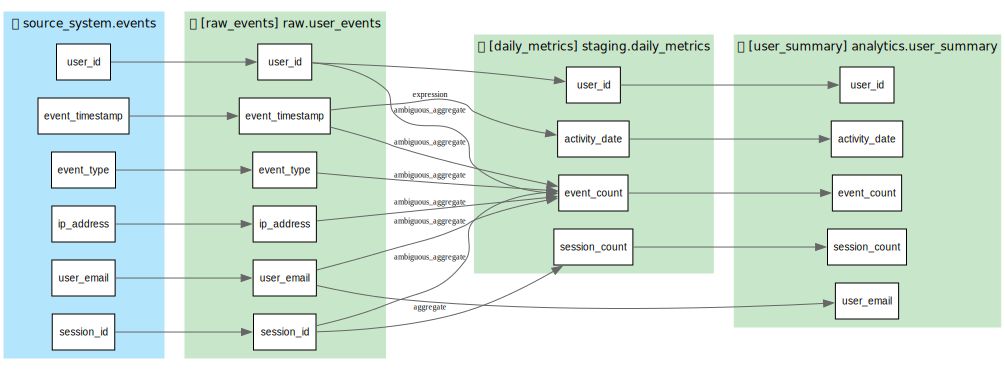

In [9]:
import shutil

# Visualize the full pipeline lineage (inline rendering)
if shutil.which("dot") is None:
    print("⚠️  Graphviz not installed. Install with: brew install graphviz")
    print("   Skipping visualization...")
else:
    print("Pipeline Column Lineage Graph:")
    display(visualize_pipeline_lineage(pipeline))

Simplified Lineage (Source → Final tables):


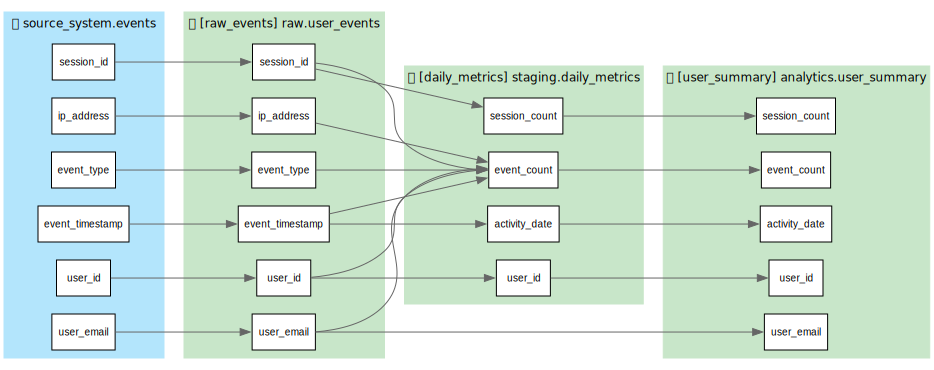

In [10]:
# Simplified view showing only source to final table relationships
if shutil.which("dot") is not None:
    print("Simplified Lineage (Source → Final tables):")
    display(visualize_pipeline_lineage(pipeline.column_graph.to_simplified()))